# Reference

https://stackoverflow.com/questions/31428581/incremental-pca-on-big-data

In [1]:
import h5py
import numpy as np
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

# Settings

In [2]:
fileName = 'matrices_big_data.h5'
numberOfComponents = 2

vectorSize = 10000
vectorsShape = (1,vectorSize)
numberOfVectorsPerFamily = 20833
randomAmplitude = 0.3

zeroVector = np.zeros(vectorsShape)
onesVector = np.ones(vectorsShape)
oscilatingVector = np.ones(vectorsShape)
for i in range(1,vectorSize,2):
    oscilatingVector[0,i] = -1

# Create Dataset

In [3]:
hdf5File = h5py.File(fileName, 'w') # approx 5 GB file

hdf5File.create_dataset('data', shape=(3*numberOfVectorsPerFamily,vectorSize), dtype=np.float_)
for i in range(numberOfVectorsPerFamily):
    hdf5File['data'][(3*i+0)*vectorSize:(3*i+1)*vectorSize] = zeroVector + np.random.uniform(low=-randomAmplitude, high=randomAmplitude, size=vectorsShape)
    hdf5File['data'][(3*i+1)*vectorSize:(3*i+2)*vectorSize] = onesVector + np.random.uniform(low=-randomAmplitude, high=randomAmplitude, size=vectorsShape)
    hdf5File['data'][(3*i+2)*vectorSize:(3*i+3)*vectorSize] = oscilatingVector + np.random.uniform(low=-randomAmplitude, high=randomAmplitude, size=vectorsShape)
hdf5File.close()

# Incremental PCA

In [4]:
hdf5File = h5py.File(fileName)
data = hdf5File['data'] # it's ok, the dataset is not fetched to memory yet

numberOfRows = data.shape[0] # how many rows we have in the dataset
chunk_size = 1000 # how many rows we feed to IPCA at a time, the divisor of n
ipca = IncrementalPCA(n_components=numberOfComponents, batch_size=16)

for i in range(0, numberOfRows//chunk_size):
    ipca.partial_fit(data[i*chunk_size : (i+1)*chunk_size])

ipca.partial_fit(data[(numberOfRows//chunk_size)*chunk_size: ])

IncrementalPCA(batch_size=16, copy=True, n_components=2, whiten=False)

# Singular Values Plot

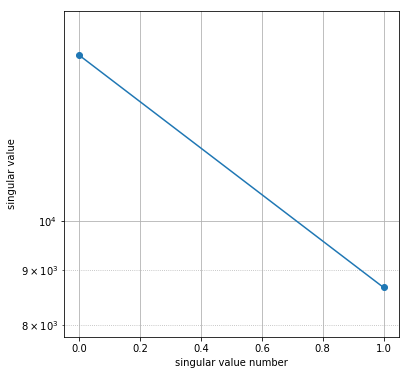

In [5]:
plt.figure(figsize=(6,6))
plt.plot(range(len(ipca.singular_values_)), ipca.singular_values_, marker='o')
plt.yscale('log')
plt.grid(True)
plt.grid(axis='y', which='minor', b=True, linestyle=':')
plt.xlabel('singular value number')
plt.ylabel('singular value')
plt.ylim([0.9*np.amin(ipca.singular_values_), 1.1*np.amax(ipca.singular_values_)])

plt.show()

# Data Decomposition in the Two Most Important Directions

In [6]:
sigma = np.zeros((3*numberOfVectorsPerFamily,2))

numberOfRows = data.shape[0]
chunk_size = 1000 # how many rows we will process at once

for i in range(0, numberOfRows//chunk_size):
    sigma[i*chunk_size : (i+1)*chunk_size] = ipca.transform(data[i*chunk_size : (i+1)*chunk_size])

sigma[(numberOfRows//chunk_size)*chunk_size:] = ipca.transform(data[(numberOfRows//chunk_size)*chunk_size:])

# Clusters

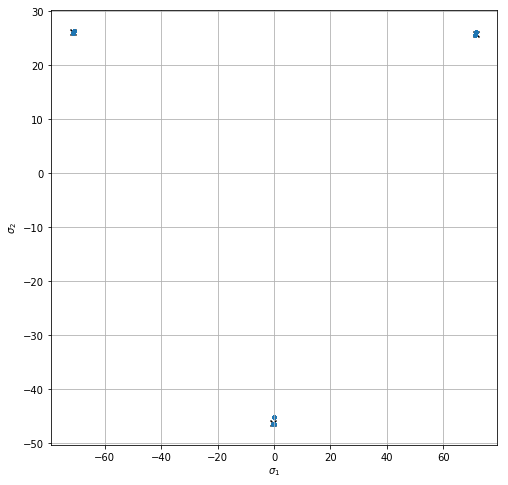

In [7]:
import scipy.cluster.vq

plt.figure(figsize=(8,8))

clusters, _ = scipy.cluster.vq.kmeans(sigma, k_or_guess=3)
plt.scatter(clusters[:,0], clusters[:,1], marker='x', color='k', label='Clusters')

plt.scatter(sigma[:,0], sigma[:,1], marker='.')
plt.grid(True)
plt.xlabel('$\sigma_1$')
plt.ylabel('$\sigma_2$')

plt.show()

# Analysis

I monitored the computer memory and CPU usage.
The CPU is high when processing for all the computer cores. That's ok.
The memory remained controlled during the processing time.
It is good because it doesn't get full, and teh system functions
remain controlled.

The above Notebook can be used as reference to process big data.